In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

from functions import missing_data_df, modify_features, encode_ordinal, impute_null

## Loading the data

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Load the data
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

df['PriceSF'] = df.SalePrice / df.GrLivArea

df = df[df.SaleCondition == 'Normal']

df shape: (2580, 80)


In [4]:
# Save 2010 data for predicting
print(df.YrSold.value_counts(normalize=True))

df_2010 = df[df['YrSold']==2010].reset_index(drop=True)
df = df[df['YrSold']<2010].reset_index(drop=True)

2009    0.232394
2007    0.229909
2008    0.220795
2006    0.192212
2010    0.124689
Name: YrSold, dtype: float64


## Missing data

In [5]:
# Check for missing values
missing_data_df(df)

,Count,Percent
PoolQC,2104,99.574065
MiscFeature,2037,96.403218
Alley,1975,93.469001
Fence,1679,79.460483
FireplaceQu,1002,47.420729
LotFrontage,405,19.167061
GarageYrBlt,97,4.590629
GarageFinish,97,4.590629
GarageQual,97,4.590629
GarageCond,97,4.590629


In [6]:
# We will drop the PoolQC and PoolArea features since more that 99% of houses don't have a pool.
df.drop(columns=['PoolQC', 'PoolArea'], inplace=True)

### Imputing null values

In [7]:
df = impute_null(df)
df_2010 = impute_null(df_2010)

## EDA

##### Numerical Features:

`['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                      'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']`

##### Discrete Features:

`['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                     'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                     'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSSubClass']`

##### Nominal Features:

`['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
                    'GarageType', 'SaleType']`

##### Ordinal Features:

`['LotShape', 'Utilities', 'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'OverallQual', 'OverallCond']`

## Feature Engineering

In [8]:
# Create HouseAge and RemodAge feature.
# Modify features with categories with very few data points.
# Binarize features where only a few categories appear to be correlated to SalesPrice.

df = modify_features(df)
df_2010 = modify_features(df_2010)


In [9]:
# Encode ordinal features into numbers.

df = encode_ordinal(df)
df_2010 = encode_ordinal(df_2010)

In [10]:
# Create a Location feature

def add_location(x):
    if 'MeadowV' in x or 'BrDale' in x or 'IDOTRR' in x or 'OldTown' in x or 'Blueste' in x or 'Edwards' in x or 'BrkSide' in x:
        return 1
    elif 'Sawyer' in x or 'Landmrk' in x or 'SWISU' in x or 'NAmes' in x or 'NPkVill' in x or 'Mitchel' in x or 'NWAmes' in x:
        return 2
    elif 'Gilbert' in x or 'SawyerW' in x or 'Blmngtn' in x or 'Crawfor' in x or 'CollgCr' in x or 'ClearCr' in x or 'Greens' in x:
        return 3
    else:
        return 4


def add_zoning(x):
    if 'RL' in x or 'FV' in x:
        return 0
    else:
        return 1


df['Location'] = df.Neighborhood.map(add_location)
df_2010['Location'] = df_2010.Neighborhood.map(add_location)

df['Zone'] = df.MSZoning.map(add_zoning)
df_2010['Zone'] = df_2010.MSZoning.map(add_zoning)

In [11]:
# Dummies Location
df = pd.get_dummies(df
               ,columns = ['Location']
               ,drop_first = True
               )

df_2010 = pd.get_dummies(df_2010
               ,columns = ['Location']
               ,drop_first = True
               )

# Dummies Dwell Type
df = pd.get_dummies(df
               ,columns = ['BldgType']
               ,drop_first = True
               )

df_2010 = pd.get_dummies(df_2010
               ,columns = ['BldgType']
               ,drop_first = True
               )


# Model

In [12]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 'GarageCars',
                        'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'FullBath', 
                        #'HouseAge', 
                        'TotRmsAbvGrd', '2ndFlrSF', 
                        'OverallCond', 'ExterCond', 'Location_2', 'Location_3', 
                        'Location_4', 'Fireplaces', 'LotFrontage', 
                        'Zone', 
                        'LotArea',
                        'MSSubClass', 'GoodGarageType', 'BsmtUnfSF', 'YearBuilt']
                        

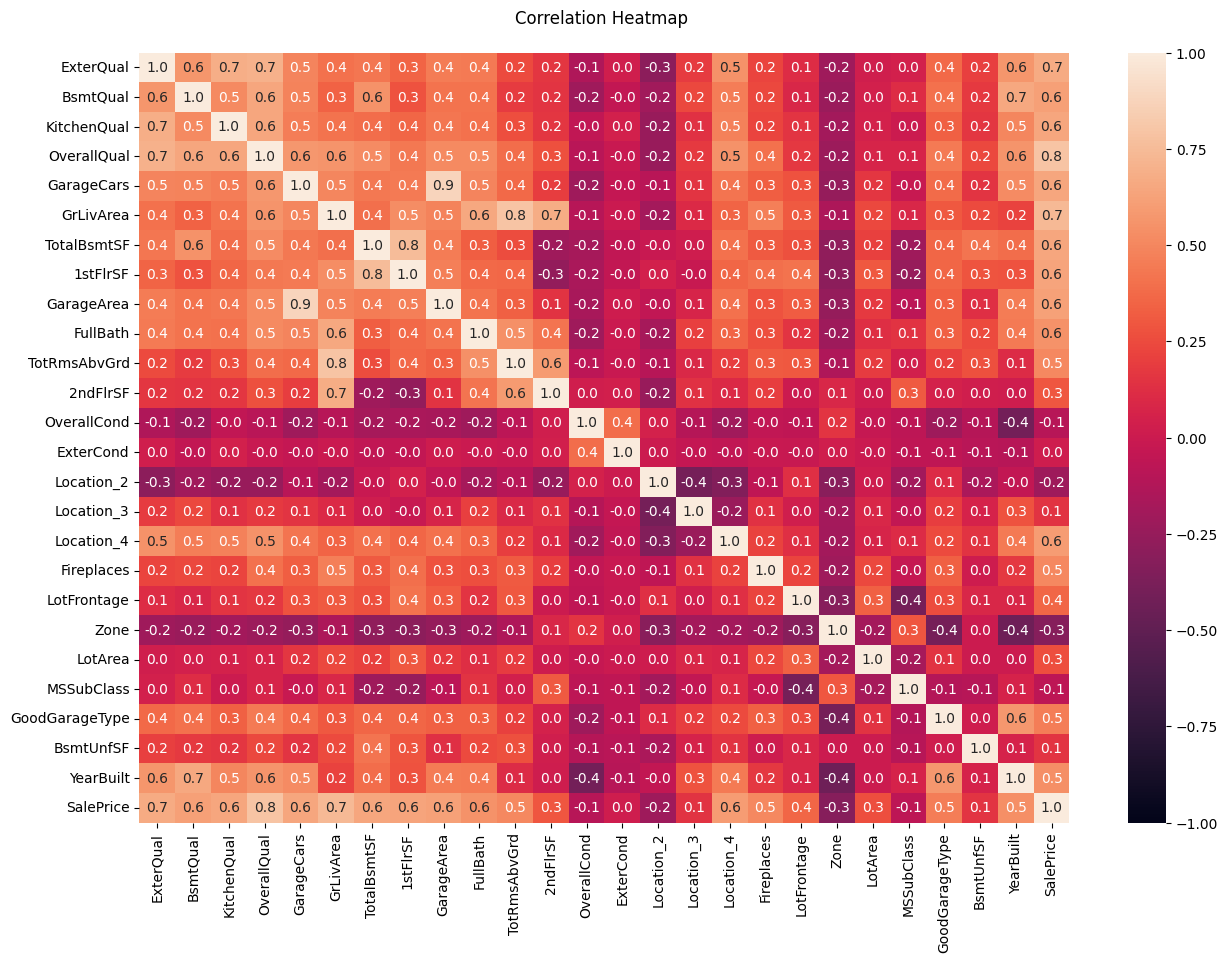

In [13]:
plt.figure(figsize=(15, 10))

corr_mat = df[feature_selection + ['SalePrice']].corr()
high_corr_mat = corr_mat[abs(corr_mat) >= 0]

sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1)
title = plt.title('Correlation Heatmap \n')

In [14]:
from sklearn.preprocessing import StandardScaler

df = df.reset_index(drop=True)
df_2010 = df_2010.reset_index(drop=True)

scaler = StandardScaler()

X_train = df[feature_selection]
y_train = np.log(df['SalePrice'])

X_test= df_2010[feature_selection]
y_test = np.log(df_2010['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Linear Regression

In [15]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9056 0.9279 0.9272 0.931  0.9416]
Mean shuffled cross validation score: 0.9267
RMSE Shuffled cross validation score: [0.1073 0.1043 0.0981 0.1013 0.0902]
RMSE Mean shuffled cross validation score: 0.1002


In [16]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))


from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9187
RMSE Test score: 0.1019


In [17]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17678.171380163174
17771.91495169939


In [18]:
predictions = ols.predict(X_train_scaled)
error_term = (y_train - predictions)
error_term.describe()

count    2.113000e+03
mean    -1.222349e-15
std      9.900081e-02
min     -7.821509e-01
25%     -5.653364e-02
50%      3.162288e-04
75%      5.956735e-02
max      5.170021e-01
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'OLS Residuals')

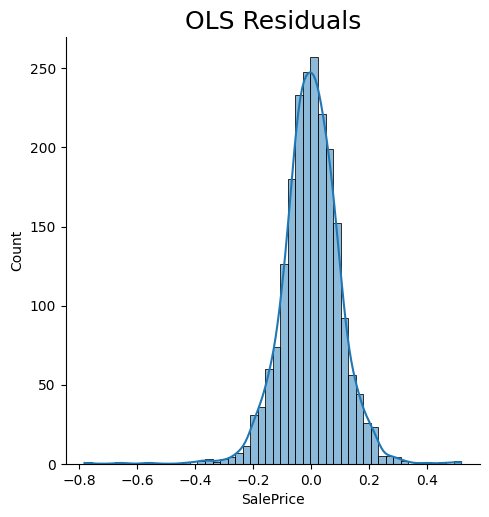

In [19]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

sns.displot(residuals, bins=50, kde=True)
plt.title(f'OLS Residuals', fontsize=18)

((array([-3.40734933, -3.15732323, -3.01870147, ...,  3.01870147,
          3.15732323,  3.40734933]),
  array([-0.78215087, -0.65723397, -0.55892387, ...,  0.46363718,
          0.50362215,  0.51700211])),
 (0.09736108955090708, -1.2397451875680483e-15, 0.9822563774142055))

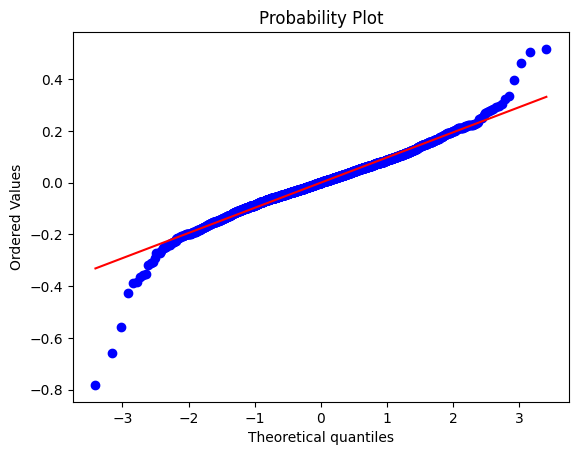

In [20]:
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)

In [21]:
from scipy import stats
res = stats.shapiro(residuals)
res.statistic

0.9665647149085999

In [22]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

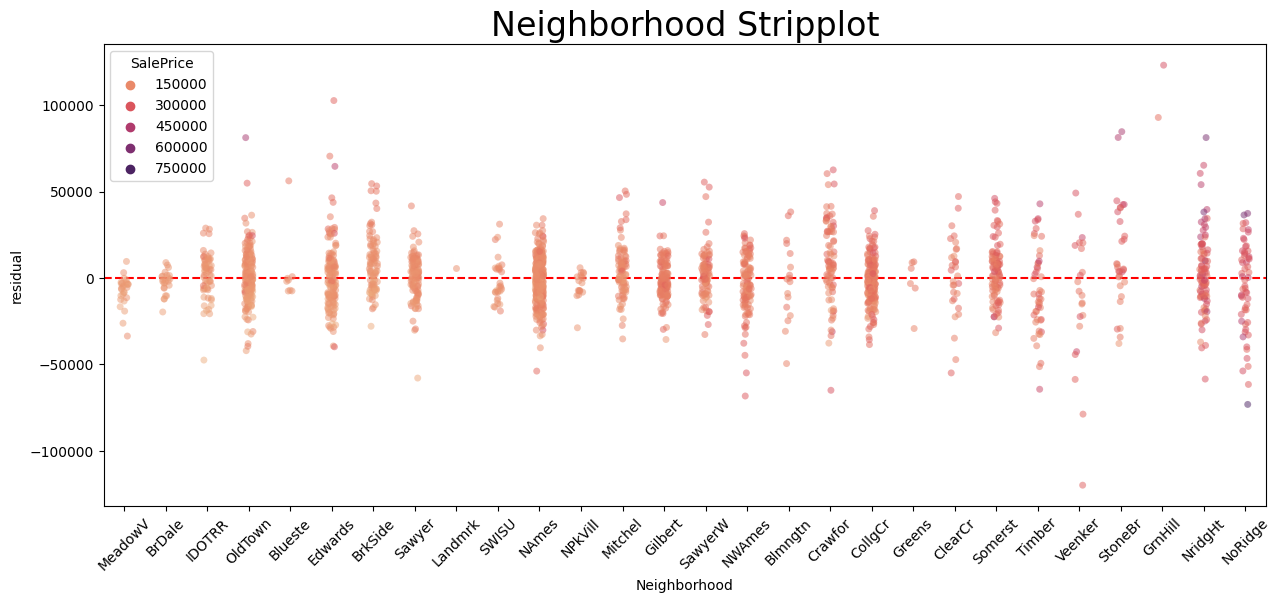

In [36]:
fig, ax = plt.subplots(figsize=(15,6))
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

sns.stripplot(data = results, x = 'Neighborhood', y = 'residual',
              jitter=0.1, 
              alpha=0.5, 
              ax=ax, 
              hue='SalePrice', 
              palette='flare',
              order = order
              )

ax.axhline(0, ls='--', color='red')
plt.title('Neighborhood Stripplot', fontsize=24)
plt.xticks(rotation=45)
plt.show()

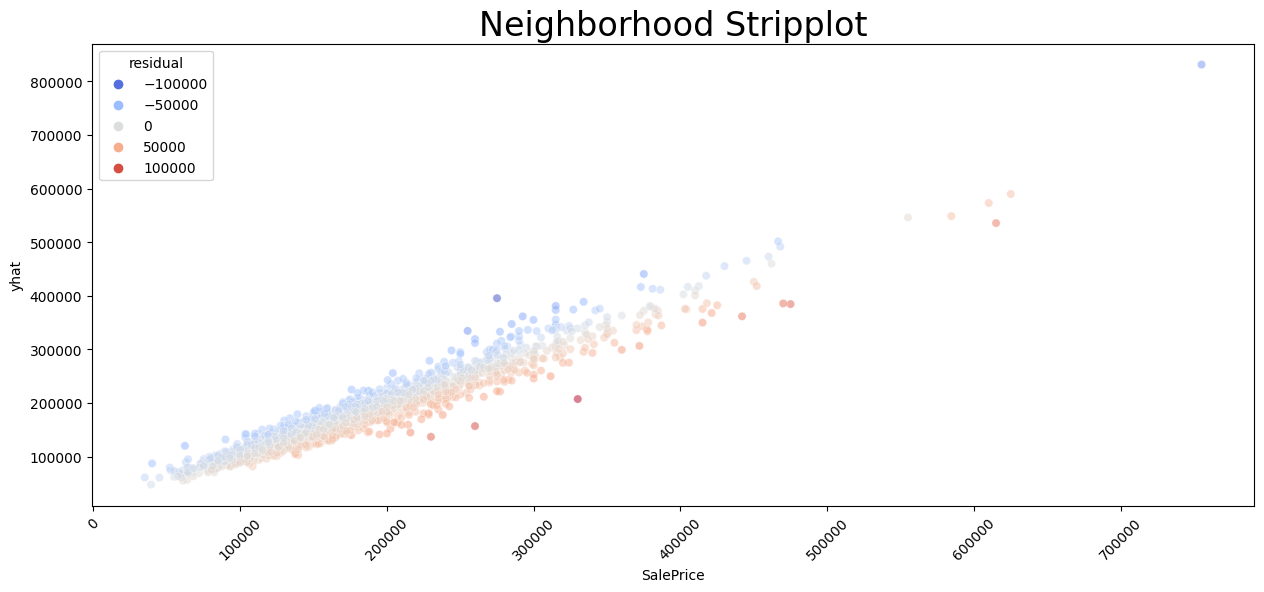

In [24]:
fig, ax = plt.subplots(figsize=(15,6))

sns.scatterplot(data = results, x = 'SalePrice', y = 'yhat',
              alpha=0.5, ax=ax, hue='residual', palette="coolwarm")
plt.title('Neighborhood Stripplot', fontsize=24)
plt.xticks(rotation=45)
#plt.ylim(-100000, 100000)
plt.show()

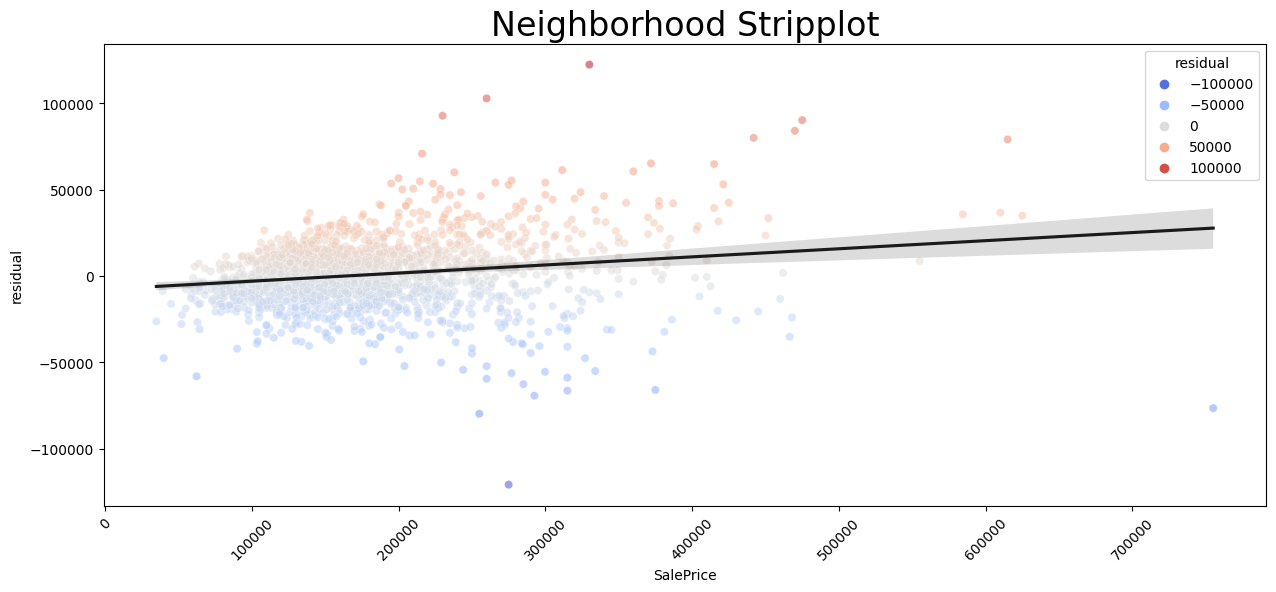

In [25]:
fig, ax = plt.subplots(figsize=(15,6))

sns.scatterplot(data = results, x = 'SalePrice', y = 'residual',
              alpha=0.5, ax=ax, hue='residual',# hue_norm=(-perc_75_res_down, perc_75_res_up), 
              palette="coolwarm")

sns.regplot(data=results, x="SalePrice", y="residual", scatter=False, color=".1")

plt.title('Neighborhood Stripplot', fontsize=24)
plt.xticks(rotation=45)
#plt.ylim(-100000, 100000)
plt.show()

## Lasso

In [26]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# Create the LassoCV model
lasso = LassoCV(cv=3)  # Set the number of cross-validation folds

# Fit the LassoCV model
lasso.fit(X_train_scaled, y_train)

# Get the best alpha value
best_alpha = lasso.alpha_

# Print the best alpha value
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


Best alpha: 0.00030416951022080486
RMSE: 0.10181646185306277


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9056 0.928  0.9274 0.9301 0.9414]
Mean shuffled cross validation score: 0.9265
RMSE Shuffled cross validation score: [0.1073 0.1042 0.098  0.1019 0.0904]
RMSE Mean shuffled cross validation score: 0.1003


In [28]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17645.939552193864
17765.801884830602


In [29]:
X_train_prov = X_train_scaled.copy()
X_train_prov['SalePrice'] = y_train
X_train_prov = X_train_prov[(df['OverallQual']>7)].reset_index(drop=True)

X_test_prov = X_test_scaled.copy()
X_test_prov['SalePrice'] = y_test
X_test_prov = X_test_prov[ (df_2010['OverallQual']>7)].reset_index(drop=True)


yhat_train = lasso.predict(X_train_prov.drop(columns='SalePrice'))
yhat_test = lasso.predict(X_test_prov.drop(columns='SalePrice'))

train_mse_non_log = mean_squared_error(np.exp(X_train_prov['SalePrice']), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(X_test_prov['SalePrice']), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

26111.349629009394
25383.601704331184


In [30]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])